In [1]:
import os
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List
from concurrent.futures import ThreadPoolExecutor, as_completed
import orjson
try:
    from tqdm.auto import tqdm
    _USE_TQDM = True
except Exception:
    _USE_TQDM = False

In [2]:
short_names = {
    "ClosestDepotMinDistanceSeedBatching": "SEEDCDMinDist",
    "RawInput": "RawInput",
    "OrderNrFiFo": "FIFOOrder",
    "FifoBatching": "FiFo",
    "DueDateBatching": "DueDate",
    "ClarkAndWrightSShape": "SavingsSShape",
    "Random": "RAND",
    "RandomBatching": "RAND",
    "ExactSolving": "TSP",
    "RatliffRosenthalRouting": "RR",
    "closest_to_depot_shared_articles_SeedBatching": "SEEDCDMaxArticles",
    "closest_to_depot_min_distance_SeedBatching": "SEEDCDMinDist",
    "RatliffRosenthalSavingsBatching": "SavingsRR",
    "NearestNeighbourhoodRouting_SavingsBatching": "SavingsNN",
    "SShapeRouting_SavingsBatching": "SavingsSShape",
    "RatliffRosenthalRouting_SavingsBatching": "SavingsRR",
    "RatliffRosenthalRouting_OrderNrFiFoBatching_LocalSearchBatching": "LSFiFoRR",
    "RatliffRosenthalRouting_RandomBatching_LocalSearchBatching": "LSRANDRR",
    "NearestNeighbourhoodRouting_RandomBatching_LocalSearchBatching": "LSRANDNN",
    "SShapeRouting": "SShape",
    "MidpointRouting": "MP",
    "LargestGapRouting": "LG",
    "ReturnRouting": "RET",
    "NearestNeighbourhoodRouting": "NN",
    "ExactTSPRoutingDistance": "TSP",
    "NearestNeighborPickLocationSelector": "NNIA",
    "GreedyPickLocationSelector": "GIA"
}

In [3]:
vis_path = "./plots/"

sns.set_style("whitegrid")
sns.set_context("talk")

fifty_shades_of_turquoise  = [
    "#40E0D0",  # Turquoise
    "#AFEEEE",  # Light Turquoise
    "#48D1CC",  # Medium Turquoise
    "#00CED1",  # Dark Turquoise
    "#E0FFFF",  # Pale Turquoise
    "#08E8DE",  # Bright Turquoise
    "#00FFEF",  # Turquoise Blue
    "#A0D6B4",  # Turquoise Green
    "#52F1FF",  # Celeste
    "#0ABAB5"   # Tiffany Blue
]

turquoise_palette = sns.color_palette(fifty_shades_of_turquoise)

In [4]:
def load_summary_jsons(base_path: str, sets_to_load: list[str]) -> List[Dict]:
    """
    Load all summary JSON files from the specified directory structure.
    """
    summary_data = []
    
    # Walk through all directories
    for instance_set in os.listdir(base_path):
        if instance_set not in sets_to_load: # , "BahceciOencan"
            continue
        instance_set_path = os.path.join(base_path, instance_set)
        
        # Skip if not a directory
        if not os.path.isdir(instance_set_path):
            continue
            
        for inst in os.listdir(instance_set_path):
            inst_path = os.path.join(instance_set_path, inst)
            
            # Skip if not a directory
            if not os.path.isdir(inst_path):
                continue
                
            for content in os.listdir(inst_path):
                # Filter only files that end with "summary.json"
                if content.endswith("summary.json"):
                    file_path = os.path.join(inst_path, content)
                    # print(f"Loading: {file_path}")
                    
                    try:
                        # Load the JSON file
                        with open(file_path, "r") as f:
                            data = json.load(f)
                            
                        # Add file path info
                        data["file_path"] = file_path
                        summary_data.append(data)
                    except Exception as e:
                        print(f"Error loading {file_path}: {e}")
    
    return summary_data

In [5]:
def create_summary_dataframe(summary_data: List[Dict]) -> pd.DataFrame:
    rows = []
    
    for data in summary_data:
        # Base information
        row = {
            "instance_name": data.get("instance_name", None),
            "instance_set": data.get("instance_set", None),
            "item_assignment_algo": data.get("item_assignment_algo", None),
            "routing_algo": data.get("routing_algo", None),
            "batching_algo": data.get("batching_algo", None),
            "scheduling_algo": data.get("scheduling_algo", None),
            "total_distance": data.get("tours_summary", {}).get("total_distance", 0),
            "routing_input_time": data.get("tours_summary", {}).get("routing_input_time", 0),
            "makespan": data.get("makespan", None),
            "on_time_rate": data.get("on_time_rate", None),
            "avg_tardiness": data.get("avg_tardiness", None),
            "max_lateness": data.get("max_lateness", None),
            "max_tardiness": data.get("max_tardiness", None),
            "avg_lateness": data.get("avg_lateness", None),
        }
        
        # Batch distance statistics
        batch_distances = data.get("tours_summary", {}).get("tour_distances", {})
        batch_times = data.get("tours_summary", {}).get("time_per_tour", {})
        batch_cpu_time = data.get("tours_summary", {}).get("routing_input_time")
        if batch_distances:
            distances = [dist for _, dist in batch_distances.items()]
            
            row.update({
                "num_batches": len(distances),
                "min_batch_distance": min(distances) if distances else 0,
                "max_batch_distance": max(distances) if distances else 0,
                "avg_batch_distance": sum(distances) / len(distances) if distances else 0,
                "median_batch_distance": np.median(distances) if distances else 0,
                "std_batch_distance": np.std(distances) if distances else 0
            })
        if batch_times:
            times = [t for _, t in batch_times.items()]
            
            row.update({
                "min_route_time": min(times) if times else 0,
                "max_route_time": max(times) if times else 0,
                "avg_route_time": sum(times) / len(times) if times else 0,
                "median_route_time": np.median(times) if times else 0,
                "std_batch_distance": np.std(times) if times else 0,
                "total_route_time": sum(times),
            })
        
        rows.append(row)
    
    return pd.DataFrame(rows)

In [6]:
def _collect_paths_by_set(base_path: str, sets_to_load: list[str]) -> dict[str, list[Path]]:
    base = Path(base_path)
    by_set: dict[str, list[Path]] = {}
    for s in sets_to_load:
        inst_set_dir = base / s
        if not inst_set_dir.is_dir():
            continue
        paths = []
        for inst_dir in inst_set_dir.iterdir():
            if inst_dir.is_dir():
                for p in inst_dir.iterdir():
                    if p.is_file() and p.name.endswith("summary.json"):
                        paths.append(p)
        if paths:
            by_set[s] = paths
    return by_set

def _load_one(path: Path) -> dict | None:
    try:
        data = orjson.loads(path.read_bytes())
        data["file_path"] = str(path)
        return data
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None

def load_summary_jsons_fast(base_path: str, sets_to_load: list[str]) -> list[dict]:
    by_set = _collect_paths_by_set(base_path, sets_to_load)
    all_data: list[dict] = []
    total_sets = len(by_set)
    done_sets = 0

    for s, paths in by_set.items():
        ok = 0
        errs = 0
        desc = f"{s} ({len(paths)} files)"
        if _USE_TQDM:
            pbar = tqdm(total=len(paths), desc=desc, leave=False)
        # File-level parallelism per set
        with ThreadPoolExecutor(max_workers=os.cpu_count() or 8) as ex:
            futures = {ex.submit(_load_one, p): p for p in paths}
            for fut in as_completed(futures):
                res = fut.result()
                if res is None:
                    errs += 1
                else:
                    ok += 1
                    all_data.append(res)
                if _USE_TQDM:
                    pbar.update(1)
        if _USE_TQDM:
            pbar.close()

        done_sets += 1
        print(f"[{done_sets}/{total_sets}] Finished {s}: {ok} ok, {errs} errors")

    return all_data

In [7]:
def build_strategy(row):
    cols = ["item_assignment_algo", "batching_algo", "routing_algo", "scheduling_algo"]
    parts = [str(row[c]) for c in cols if pd.notna(row[c]) and row[c] != ""]
    return "+".join(parts)

In [8]:
base_path = "../output/" 
cache_path = "./df_results.pkl"

In [9]:
# sets_to_load = ["Foodmart,
# IOPVRP, 
# BahceciOencan",
# "SPRP-SS"]  # uncomment this only if you want to load new results, else read the pickled df

sets_to_load = None
df = pd.read_pickle(cache_path)
print(df.groupby(by="instance_set").agg({"instance_name": "count"}))
df_summary = pd.DataFrame()
if sets_to_load: 
    summary_data = load_summary_jsons_fast(base_path, sets_to_load)
    print(f"Loaded {len(summary_data)} summary files")
    df_summary = create_summary_dataframe(summary_data)

if not df_summary.empty:
    replace_sets = set(df_summary["instance_set"].unique())
    if not df.empty and "instance_set" in df.columns:
        df = df[~df["instance_set"].isin(replace_sets)]
    df = pd.concat([df, df_summary], ignore_index=True)

df["item_assignment_algo"] = df["item_assignment_algo"].replace(short_names)
df["batching_algo"] = df["batching_algo"].replace(short_names)
df["routing_algo"] = df["routing_algo"].replace(short_names)
df["strategy"] = df.apply(build_strategy, axis=1)
df["total_cpu_time"] = df["routing_input_time"] + df["total_route_time"]

# Save updated cache
df.to_pickle(cache_path)
print("\nDataFrame Summary:")
# print(df.head())
print(df.groupby(by="instance_set").agg({"instance_name": "count"}))
# print(f"\nDataFrame Shape: {df.shape}")

               instance_name
instance_set                
BahceciOencan          72900
FoodmartData            4905
IOPVRP                 61600
SPRP-SS               171600

DataFrame Summary:
               instance_name
instance_set                
BahceciOencan          72900
FoodmartData            4905
IOPVRP                 61600
SPRP-SS               171600


In [10]:
pipeline_results_overview = df.groupby("instance_set").agg(
    n_item_assignment_algos=("item_assignment_algo", "nunique"),
    n_routing_algos=("routing_algo", "nunique"),
    n_pick_list_gen_algos=("batching_algo", "nunique"),
    n_scheduling_algos=("scheduling_algo", "nunique"),
    n_instances=("instance_name", "nunique"),
    n_pipelines=("total_distance", "count")
)

In [11]:
pipeline_results_overview_tex = pipeline_results_overview.to_latex(index=True, caption="Pipeline results overview", label="tab:pipeline_results", escape=True)

In [12]:
pipeline_results_overview

,n_item_assignment_algos,n_routing_algos,n_pick_list_gen_algos,n_scheduling_algos,n_instances,n_pipelines
instance_set,,,,,,
BahceciOencan,1,6,9,0,1350,72900
FoodmartData,1,5,7,0,141,4905
IOPVRP,1,5,11,3,160,61600
SPRP-SS,2,6,1,0,14300,171600


In [13]:
print(pipeline_results_overview_tex)

\begin{table}
\caption{Pipeline results overview}
\label{tab:pipeline_results}
\begin{tabular}{lrrrrrr}
\toprule
 & n\_item\_assignment\_algos & n\_routing\_algos & n\_pick\_list\_gen\_algos & n\_scheduling\_algos & n\_instances & n\_pipelines \\
instance_set &  &  &  &  &  &  \\
\midrule
BahceciOencan & 1 & 6 & 9 & 0 & 1350 & 72900 \\
FoodmartData & 1 & 5 & 7 & 0 & 141 & 4905 \\
IOPVRP & 1 & 5 & 11 & 3 & 160 & 61600 \\
SPRP-SS & 2 & 6 & 1 & 0 & 14300 & 171600 \\
\bottomrule
\end{tabular}
\end{table}



In [14]:
def vbs_row(df, metric_col="total_distance", strategy_col="strategy", instance_col="instance_name", min_max="min"):
    """
    Performs VBS vs SBS analysis grouped by a category (e.g., storage policy).
    Returns a DataFrame with SBS mean, VBS mean, mean regret, and relative gain per group.
    """
    results = []
    # VBS per instance
    if min_max == "min":
        vbs_per_instance = df.groupby(instance_col)[metric_col].min() 
    else:
        vbs_per_instance = df.groupby(instance_col)[metric_col].max()
    vbs_strategies = df.loc[df.groupby("instance_name")[metric_col].idxmin(), ["instance_name", "strategy"]]
    vbs_mean = vbs_per_instance.mean() 
        
    results.append({
        "instance_set": df_instance["instance_set"].unique()[0],
        "SBS Strategy": sbs_strategy,
        "VBS Mean": vbs_mean,
    })
    
    return pd.DataFrame(results), winner_counts

In [15]:
def vbs_analysis(df, metric_col="total_distance", strategy_col="strategy", instance_col="instance_name", min_max="min"):
    """
    Performs VBS vs SBS analysis grouped by a category (e.g., storage policy).
    Returns a DataFrame with SBS mean, VBS mean, mean regret, and relative gain per group.
    """
    results = []
    # VBS per instance
    if min_max == "min":
        vbs_per_instance = df.groupby(instance_col)[metric_col].min() 
    else:
        vbs_per_instance = df.groupby(instance_col)[metric_col].max()
    vbs_strategies = df.loc[df.groupby("instance_name")[metric_col].idxmin(), ["instance_name", "strategy"]]
    vbs_mean = vbs_per_instance.mean() 
    
    # SBS (best on average in group)
    avg_by_strategy = df.groupby(strategy_col)[metric_col].mean()
    if min_max == "min":
        sbs_strategy = avg_by_strategy.idxmin()
        sbs_mean = avg_by_strategy.min()
    else:
        sbs_strategy = avg_by_strategy.idxmax()
        sbs_mean = avg_by_strategy.max()
    # SBS performance per instance
    sbs_perf_per_instance = df[df[strategy_col] == sbs_strategy].set_index(instance_col)[metric_col]
    winner_counts = vbs_strategies["strategy"].value_counts()
    if min_max == "min":
        # lower is better
        regret = sbs_perf_per_instance - vbs_per_instance
        rel_gain = 100 * (sbs_mean - vbs_mean) / sbs_mean
    else:
        # higher is better
        regret = vbs_per_instance - sbs_perf_per_instance
        rel_gain = 100 * (vbs_mean - sbs_mean) / sbs_mean
        
    results.append({
        "instance_set": df_instance["instance_set"].unique()[0],
        "SBS Strategy": sbs_strategy,
        "SBS Mean": sbs_mean,
        "VBS Mean": vbs_mean,
        # "Mean Regret": mean_regret,
        "Relative Gain %": rel_gain
    })
    
    return pd.DataFrame(results), winner_counts

In [16]:
def plot_winners(winner_counts: pd.DataFrame()):
    plt.figure(figsize=(8,4))
    top_winners = winner_counts.head(10)
    sns.barplot(x=top_winners.values, y=top_winners.index, palette="Blues_r", hue=top_winners.index, legend=False)
    plt.xlabel("Number of Instances Won")
    plt.ylabel("Strategy")
    plt.title("Top Winning Strategies (VBS)")
    plt.tight_layout()
    plt.show()
    
def plot_winners_pareto(winner_counts: pd.DataFrame()):
    plt.figure(figsize=(8,6))
    winner_percent = winner_counts / winner_counts.sum() * 100
    winner_percent.sort_values().plot(kind='barh', color='skyblue')
    plt.xlabel("Percentage of Instances Won (%)")
    plt.ylabel("Strategy")
    plt.title("Overall VBS Winner Distribution")
    plt.show()

In [17]:
# df = df[~df["batching_algo"].isin(["ClarkAndWrightBatching", "SEEDCDMaxArticles"])]

SPRP-SS
                strategy  count  relative_%
0       NNIA+RawInput+RR   6248   43.692308
1        GIA+RawInput+RR   4184   29.258741
2       NNIA+RawInput+NN    802    5.608392
3      NNIA+RawInput+RET    744    5.202797
4       NNIA+RawInput+LG    630    4.405594
5       NNIA+RawInput+MP    566    3.958042
6        GIA+RawInput+NN    435    3.041958
7        GIA+RawInput+LG    213    1.489510
8    GIA+RawInput+SShape    187    1.307692
9   NNIA+RawInput+SShape    120    0.839161
10       GIA+RawInput+MP    118    0.825175
11      GIA+RawInput+RET     53    0.370629


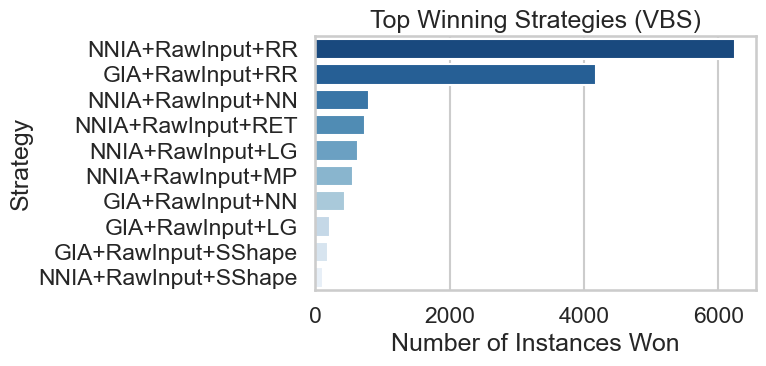

BahceciOencan
                    strategy  count  relative_%
0           GIA+SavingsNN+RR    418   30.962963
1            GIA+LSFiFoRR+RR    360   26.666667
2       GIA+SEEDCDMinDist+RR    190   14.074074
3           GIA+SavingsRR+RR     80    5.925926
4            GIA+LSFiFoRR+NN     58    4.296296
5          GIA+SavingsNN+RET     36    2.666667
6            GIA+LSFiFoRR+LG     31    2.296296
7       GIA+SEEDCDMinDist+LG     28    2.074074
8           GIA+SavingsRR+LG     27    2.000000
9       GIA+SavingsSShape+RR     22    1.629630
10     GIA+SavingsSShape+RET     19    1.407407
11      GIA+SavingsSShape+NN     19    1.407407
12  GIA+SavingsSShape+SShape     17    1.259259
13           GIA+LSFiFoRR+MP     13    0.962963
14  GIA+SEEDCDMaxArticles+RR      9    0.666667
15          GIA+LSFiFoRR+RET      4    0.296296
16      GIA+SEEDCDMinDist+MP      4    0.296296
17  GIA+SEEDCDMaxArticles+MP      3    0.222222
18           GIA+LSRANDNN+RR      2    0.148148
19           GIA+LSRANDNN+

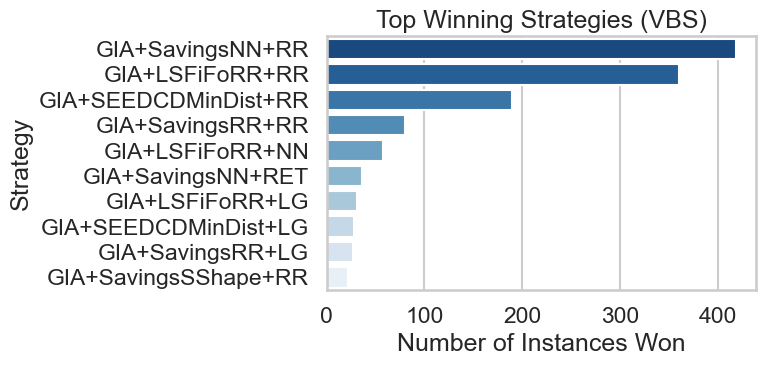

IOPVRP
                                             strategy  count  relative_%
0   GIA+NearestNeighbourhoodRouting_FiFoBatching_L...     43      26.875
1   GIA+NearestNeighbourhoodRouting_FiFoBatching_L...     34      21.250
2   GIA+NearestNeighbourhoodRouting_DueDateBatchin...     19      11.875
3                   GIA+RawInput+SShape+SPTScheduling     17      10.625
4   GIA+NearestNeighbourhoodRouting_DueDateBatchin...     15       9.375
5                   GIA+LSRANDNN+SShape+SPTScheduling      9       5.625
6                       GIA+DueDate+RET+SPTScheduling      8       5.000
7                  GIA+SavingsSShape+NN+LPTScheduling      6       3.750
8                       GIA+FiFo+SShape+SPTScheduling      4       2.500
9                           GIA+RAND+MP+EDDScheduling      2       1.250
10                  GIA+LSRANDNN+SShape+LPTScheduling      1       0.625
11             GIA+SEEDCDMaxArticles+NN+EDDScheduling      1       0.625
12                       GIA+DueDate+MP+EDDS

C:\Users\zm0714\AppData\Local\Temp\ipykernel_1188\2581147529.py:29: RuntimeWarning: invalid value encountered in scalar divide
  rel_gain = 100 * (sbs_mean - vbs_mean) / sbs_mean
C:\Users\zm0714\AppData\Local\Temp\ipykernel_1188\4163562552.py:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


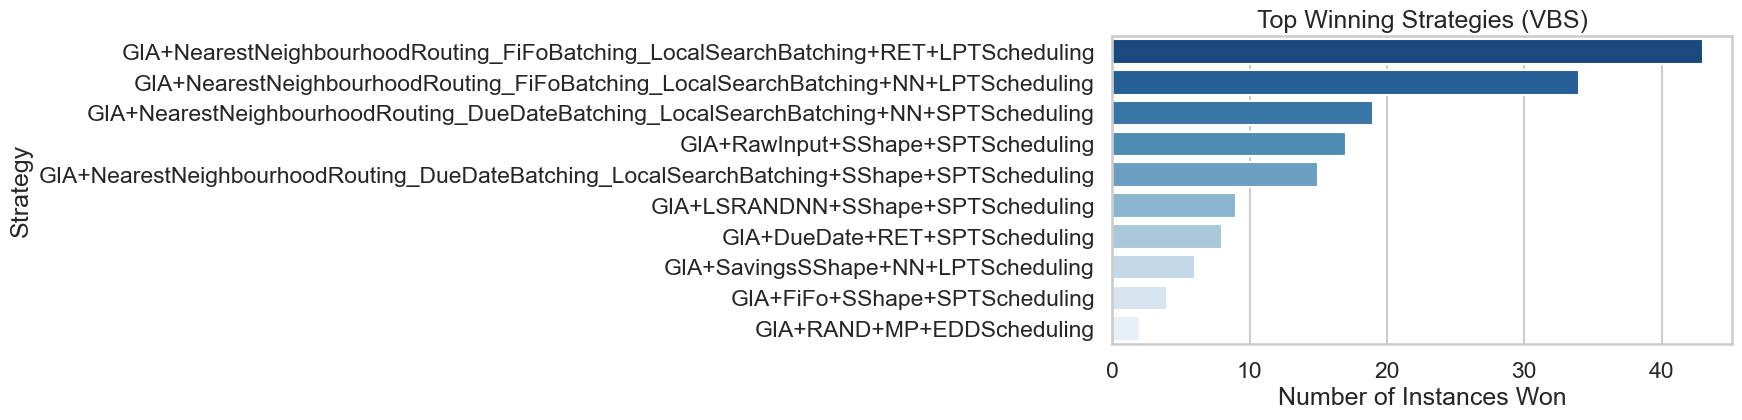

FoodmartData
                   strategy  count  relative_%
0           GIA+LSRANDNN+NN    118   83.687943
1          GIA+SavingsNN+NN      9    6.382979
2      GIA+SavingsSShape+NN      6    4.255319
3  GIA+SavingsSShape+SShape      5    3.546099
4      GIA+SEEDCDMinDist+NN      1    0.709220
5  GIA+SEEDCDMaxArticles+NN      1    0.709220
6      GIA+SEEDCDMinDist+MP      1    0.709220


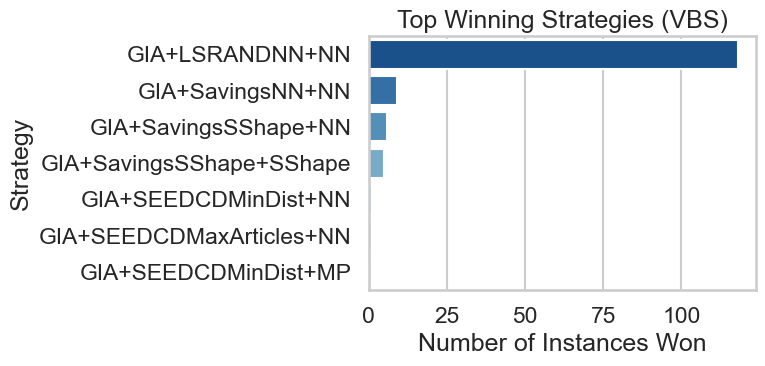

In [18]:
df_vbs_overview = pd.DataFrame()
for instance in df["instance_set"].unique():
    print(instance)
    df_instance = df[df["instance_set"]==instance]
    # df_instance["strategy"] = df_instance["batching_algo"] + "+" + df_instance["routing_algo"]
    df_instance = df_instance[~df_instance["routing_algo"].isin(["TSP"])]
    # df_instance = df_instance[~df_instance["batching_algo"].isin(["C&WSShape"])]

    result, winner_counts = vbs_analysis(df_instance)
    # winner_counts["proportions"] = winner_counts.values / sum(winner_counts.values)
    df_winners = winner_counts.reset_index()
    df_winners.columns = ["strategy", "count"]
    df_winners["relative_%"] = df_winners["count"] / df_winners["count"].sum() * 100
    print(df_winners)
    df_vbs_overview = pd.concat([df_vbs_overview, result], ignore_index=True)
    plot_winners(winner_counts) 

In [19]:
df_vbs_overview = pd.DataFrame()
df_all_winners = []  # collect winners across instance sets

for instance in df["instance_set"].unique():
    df_instance = df[df["instance_set"] == instance]
    # df_instance = df_instance[~df_instance["routing_algo"].isin(["RR", "TSP"])]
    # df_instance = df_instance[~df_instance["batching_algo"].isin(["C&WSShape"])]
    df_instance = df_instance[df_instance["total_distance"]!=0]
    result, winner_counts = vbs_analysis(df_instance)

    df_winners = winner_counts.reset_index()
    df_winners.columns = ["strategy", "count"]
    df_winners["relative_%"] = df_winners["count"] / df_winners["count"].sum() * 100
    df_winners["instance_set"] = instance  # add instance set label

    df_all_winners.append(df_winners)  # store for later

    df_vbs_overview = pd.concat([df_vbs_overview, result], ignore_index=True)

# Combine all winners into a single dataframe
df_all_winners = pd.concat(df_all_winners, ignore_index=True)

In [20]:
df_vbs_overview_tex = df_vbs_overview.round(2)

# Build column alignment: left for first col, right for the rest
colfmt = "l" + "r" * (df_vbs_overview_tex.shape[1] - 1)

# Generate LaTeX tabular
latex_tabular = df_vbs_overview_tex.to_latex(
    index=False,
    escape=True,                # escape underscores, % etc.
    na_rep="--",
    column_format=colfmt,
    float_format="%.2f"
)

# Wrap with adjustbox for page fit
df_vbs_overview_tex = rf"""
\begin{{table}}[!htbp]
\centering
\caption{{VBS overview}}
\label{{tab:vbs_overview}}
\begin{{adjustbox}}{{width=\linewidth,center}}
{latex_tabular}
\end{{adjustbox}}
\end{{table}}
"""

print(df_vbs_overview_tex)


\begin{table}[!htbp]
\centering
\caption{VBS overview}
\label{tab:vbs_overview}
\begin{adjustbox}{width=\linewidth,center}
\begin{tabular}{lrrrr}
\toprule
instance\_set & SBS Strategy & SBS Mean & VBS Mean & Relative Gain \% \\
\midrule
SPRP-SS & NNIA+RawInput+RR & 505.57 & 482.12 & 4.64 \\
BahceciOencan & GIA+LSFiFoRR+RR & 168.49 & 168.26 & 0.14 \\
IOPVRP & GIA+SavingsNN+NN & 34850.57 & 34850.57 & 0.00 \\
FoodmartData & GIA+SavingsNN+NN & 1747.75 & 2286.15 & -30.81 \\
\bottomrule
\end{tabular}

\end{adjustbox}
\end{table}



In [21]:
def grouped_vbs_analysis(df, group_col, metric_col="total_distance", strategy_col="strategy", instance_col="instance_name"):
    """
    Performs VBS vs SBS analysis grouped by a category (e.g., storage policy).
    Returns a DataFrame with SBS mean, VBS mean, mean regret, and relative gain per group.
    """
    results = []
    winner_counts = 0
    for group, subdf in df.groupby(group_col):
        # VBS per instance
        vbs_per_instance = subdf.groupby(instance_col)[metric_col].min()
        vbs_mean = vbs_per_instance.mean()
        vbs_strategies = subdf.loc[subdf.groupby("instance_name")["total_distance"].idxmin(), ["instance_name", "strategy"]]
        
        # SBS (best on average in group)
        avg_by_strategy = subdf.groupby(strategy_col)[metric_col].mean()
        sbs_strategy = avg_by_strategy.idxmin()
        sbs_mean = avg_by_strategy.min()
        
        # SBS performance per instance
        sbs_perf_per_instance = subdf[subdf[strategy_col] == sbs_strategy].set_index(instance_col)[metric_col]
        
        # Regret
        regret = sbs_perf_per_instance - vbs_per_instance
        mean_regret = regret.mean()
        rel_gain = 100 * (sbs_mean - vbs_mean) / sbs_mean
        winner_counts = vbs_strategies["strategy"].value_counts()
        
        results.append({
            group_col: group,
            "SBS Strategy": sbs_strategy,
            "SBS Mean": sbs_mean,
            "VBS Mean": vbs_mean,
            # "Mean Regret": mean_regret,
            "Relative Gain %": rel_gain
        })
    
    return pd.DataFrame(results), winner_counts

# SPRP-SS

In [22]:
instance_set = "SPRP-SS"
results = pd.read_csv(f"../../data/results/results_{instance_set}.csv", sep=";", decimal=",",      # Comma is decimal separator
    thousands=".")

In [23]:
results["demand_helper"] = results.apply(lambda row: "unit" if row["unit demand"] else "varying", axis=1)
results["filename"] = results.apply(
    lambda
        row: f"{row['demand_helper']}_F{row['alpha']}_m{row['num aisles']}_C{row['num cells']}_a{row['num articles']}_{row['random seed']}",
    axis=1
)
results.rename(columns={"GS MIP cost": "LB"}, inplace=True)
# if "LB" in results.columns:
# results["LB"] = results["LB"].astype(str).str.replace(".", ",").astype(float)

In [24]:
df_sprp_ss = df[df["instance_set"]==instance_set]

In [25]:
avg_by_strategy = df_sprp_ss.groupby("strategy")["total_distance"].mean()

In [26]:
df_sprp_ss = df_sprp_ss.merge(right=results, how="left", left_on="instance_name", right_on="filename")

In [27]:
df_sprp_ss["gap_[%]"] = ((df_sprp_ss["total_distance"] - df_sprp_ss["LB"]) / df_sprp_ss["LB"]) * 100

In [28]:
df_sprp_ss["total_cpu_time"] *= 1000

In [29]:
df_sprp_ss_vbs = (
    df_sprp_ss
    .sort_values(['total_distance', 'total_cpu_time'])
    .groupby('instance_name')
    .first()
    .reset_index()
    [['instance_name', 'strategy', 'total_distance', 'total_cpu_time', "gap_[%]"]]
)

In [30]:
row_vbs = pd.DataFrame([{
    "strategy": "VBS", 
    "mean gap": df_sprp_ss_vbs["gap_[%]"].mean(), 
    "mean runtime": df_sprp_ss_vbs["total_cpu_time"].astype(float).mean(), 
    "mean distance": df_sprp_ss_vbs["total_distance"].mean(), 
    "n instances": 1350
}])

In [31]:
pipeline_summary = df_sprp_ss.groupby('strategy').agg({
    'gap_[%]': 'mean',
    'total_cpu_time': 'mean',
    'total_distance': 'mean',
    'instance_set': 'count'
}).reset_index()

pipeline_summary.columns = ['strategy', 'mean gap', 'mean runtime', 'mean distance', 'n instances']
pipeline_summary.sort_values(by="mean gap", inplace=True)
row_best = pd.DataFrame([{
    "strategy": "best reported", 
    "mean gap": 0, 
    "mean runtime": df_sprp_ss["GS MIP time cplex [ms]"].astype(float).mean(), 
    "mean distance": df_sprp_ss["LB"].mean(), 
    "n instances": pipeline_summary["n instances"].unique().item()
}])

pipeline_summary = pd.concat([row_best, row_vbs, pipeline_summary], ignore_index=True)
print(pipeline_summary)

df_top_five_gap = pipeline_summary.round(3)

# Build column alignment: left for first col, right for the rest
colfmt = "l" + "r" * (df_top_five_gap.shape[1] - 1)

# Generate LaTeX tabular
latex_tabular = df_top_five_gap.to_latex(
    index=False,
    escape=True,                
    na_rep="--",
    column_format=colfmt,
    float_format="%.2f"
)

# Wrap with adjustbox for page fit
df_top_five_gap = rf"""
\begin{{table}}[!htbp]
\centering
\caption{{Best pipelines of SPRP}}
\label{{tab:sprp_top_five}}
\begin{{adjustbox}}{{width=\linewidth,center}}
{latex_tabular}
\end{{adjustbox}}
\end{{table}}
"""

print(df_top_five_gap)

                strategy    mean gap  mean runtime  mean distance  n instances
0          best reported    0.000000   1823.337738     345.355804        14300
1                    VBS   35.013370      5.488111     482.120140         1350
2       NNIA+RawInput+RR   41.194253      8.572505     505.570490        14300
3       NNIA+RawInput+NN   52.485993      1.821270     557.990350        14300
4       NNIA+RawInput+LG   66.409077      1.272399     599.080280        14300
5       NNIA+RawInput+MP   69.351214      1.237303     612.198462        14300
6        GIA+RawInput+RR   78.622353      7.408268     549.813147        14300
7        GIA+RawInput+NN   88.009124      1.533486     591.445315        14300
8        GIA+RawInput+LG  105.701155      1.187931     639.669930        14300
9        GIA+RawInput+MP  107.658815      1.166393     654.453007        14300
10   GIA+RawInput+SShape  123.584026      1.207726     736.049231        14300
11     NNIA+RawInput+RET  129.660667      1.314805  

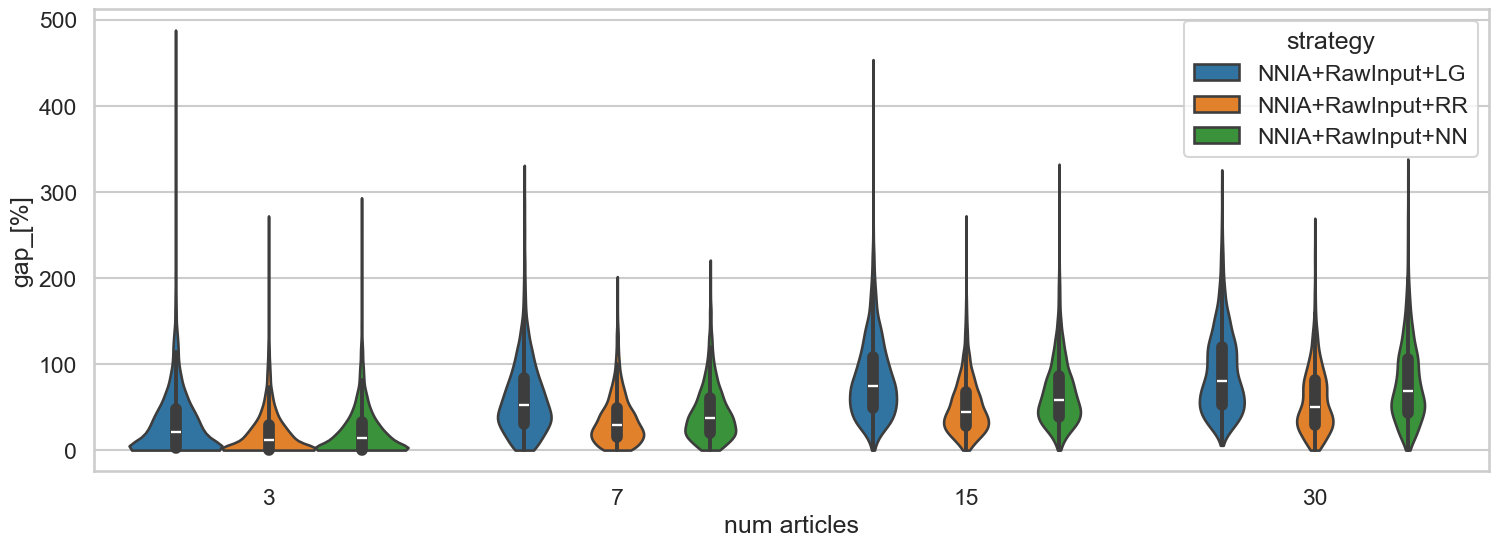

In [32]:
top_3 = ["NNIA+RawInput+RR", "NNIA+RawInput+NN",
         "NNIA+RawInput+LG"]
_, ax = plt.subplots(figsize=(18, 6))
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
ax = sns.violinplot(data=df_sprp_ss[df_sprp_ss["strategy"].isin(top_3)], x='num articles', y='gap_[%]', hue='strategy', cut=0)

# Foodmart

In [33]:
instance_set = "FoodmartData"
results = pd.read_csv(f"../../data/results/results_Foodmart.csv", sep=";", decimal=",",      # Comma is decimal separator
    thousands=".")

In [34]:
results["LB"] = results["LB"].astype(float)
results["UB"] = results["UB"].astype(float)

In [35]:
df_foodmart = df[df["instance_set"]==instance_set]
df_foodmart["instance_name"] = df_foodmart["instance_name"].str.replace(r'^instances_|_MAL$', '', regex=True)
df_foodmart = df_foodmart[~df_foodmart["instance_name"].isin(["ord2000_fsd10"])] # , "ord1000_fsd10", "ord500_fsd10", "ord200_fsd10"

C:\Users\zm0714\AppData\Local\Temp\ipykernel_1188\2640752801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_foodmart["instance_name"] = df_foodmart["instance_name"].str.replace(r'^instances_|_MAL$', '', regex=True)


In [36]:
# comment out if not benchmarking against results

df_foodmart = df_foodmart.merge(right=results, how="inner", left_on="instance_name", right_on="Name")
df_foodmart["gap_[%]"] = ((df_foodmart["total_distance"] - df_foodmart["UB"]) / df_foodmart["UB"]) * 100

In [37]:
df_foodmart_vbs = df_foodmart.loc[df_foodmart.groupby("instance_name")["total_distance"].idxmin(), ["instance_name", "strategy", "total_distance", "total_cpu_time", "gap_[%]"]]

In [38]:
df_foodmart_vbs.groupby(by="strategy").count()

,instance_name,total_distance,total_cpu_time,gap_[%]
strategy,,,,
GIA+LSRANDNN+NN,27,27,27,27
GIA+SEEDCDMaxArticles+NN,1,1,1,1
GIA+SEEDCDMinDist+NN,1,1,1,1
GIA+SavingsNN+NN,3,3,3,3
GIA+SavingsSShape+NN,5,5,5,5
GIA+SavingsSShape+SShape,5,5,5,5


In [39]:
pipeline_summary = df_foodmart.groupby('strategy').agg({
    'gap_[%]': 'mean',
    'total_cpu_time': 'mean',
    'total_distance': 'mean',
    'instance_set': 'count'
}).reset_index()

pipeline_summary.columns = ['strategy', 'mean gap', 'mean runtime', 'mean distance', 'n instances']
pipeline_summary.sort_values(by="mean distance", inplace=True)
# display(pipeline_summary)
five_worst = pipeline_summary.tail(5)
five_best = pipeline_summary.head(5)

row_best = pd.DataFrame([{
    "strategy": "best reported", 
    "mean gap": 0, 
    "mean runtime": df_foodmart["CPU Total (s)"].astype(float).mean(), 
    "mean distance": df_foodmart["LB"].mean(), 
    "n instances": df_foodmart.instance_name.nunique()
}])

row_vbs = pd.DataFrame([{
    "strategy": "VBS", 
    "mean gap": df_foodmart_vbs["gap_[%]"].mean(), 
    "mean runtime": df_foodmart_vbs["total_cpu_time"].astype(float).mean(), 
    "mean distance": df_foodmart_vbs["total_distance"].mean(), 
    "n instances": df_foodmart_vbs.instance_name.nunique()
}])

pipeline_summary = pd.concat([row_best, row_vbs, five_best, five_worst], ignore_index=True)
df_top_five_gap = pipeline_summary.round(2)
display(df_top_five_gap)
# Build column alignment: left for first col, right for the rest
colfmt = "l" + "r" * (df_top_five_gap.shape[1] - 1)

# Generate LaTeX tabular
latex_tabular = df_top_five_gap.to_latex(
    index=False,
    escape=True,                
    na_rep="--",
    column_format=colfmt,
    float_format="%.2f"
)

# Wrap with adjustbox for page fit
df_top_five_gap = rf"""
\begin{{table}}[!htbp]
\centering
\caption{{Best pipelines of Foodmart}}
\label{{tab:foodmart_top_five}}
\begin{{adjustbox}}{{width=\linewidth,center}}
{latex_tabular}
\end{{adjustbox}}
\end{{table}}
"""

,strategy,mean gap,mean runtime,mean distance,n instances
0,best reported,0.00,951.49,787.37,42
1,VBS,7.68,3.11,863.28,42
2,GIA+LSRANDNN+NN,10.40,3.35,882.61,42
3,GIA+SavingsNN+NN,13.04,0.46,905.84,42
4,GIA+SavingsSShape+SShape,15.97,0.07,934.77,42
5,GIA+SavingsNN+SShape,16.43,0.46,938.91,42
6,GIA+SEEDCDMaxArticles+SShape,16.95,0.00,943.48,42
7,GIA+RawInput+NN,256.63,0.00,2901.42,42
8,GIA+RawInput+LG,322.83,0.00,3442.61,42
9,GIA+RawInput+MP,328.45,0.00,3487.32,42


In [40]:
print(df_top_five_gap)


\begin{table}[!htbp]
\centering
\caption{Best pipelines of Foodmart}
\label{tab:foodmart_top_five}
\begin{adjustbox}{width=\linewidth,center}
\begin{tabular}{lrrrr}
\toprule
strategy & mean gap & mean runtime & mean distance & n instances \\
\midrule
best reported & 0.00 & 951.49 & 787.37 & 42 \\
VBS & 7.68 & 3.11 & 863.28 & 42 \\
GIA+LSRANDNN+NN & 10.40 & 3.35 & 882.61 & 42 \\
GIA+SavingsNN+NN & 13.04 & 0.46 & 905.84 & 42 \\
GIA+SavingsSShape+SShape & 15.97 & 0.07 & 934.77 & 42 \\
GIA+SavingsNN+SShape & 16.43 & 0.46 & 938.91 & 42 \\
GIA+SEEDCDMaxArticles+SShape & 16.95 & 0.00 & 943.48 & 42 \\
GIA+RawInput+NN & 256.63 & 0.00 & 2901.42 & 42 \\
GIA+RawInput+LG & 322.83 & 0.00 & 3442.61 & 42 \\
GIA+RawInput+MP & 328.45 & 0.00 & 3487.32 & 42 \\
GIA+RawInput+SShape & 388.18 & 0.00 & 3989.09 & 42 \\
GIA+RawInput+RET & 479.71 & 0.00 & 4732.80 & 42 \\
\bottomrule
\end{tabular}

\end{adjustbox}
\end{table}



# BahceciOencan

In [41]:
instance_set = "BahceciOencan"
results = pd.read_csv(f"../../data/results/results_{instance_set}.csv", sep=";", decimal=",",      # Comma is decimal separator
    thousands=".")

In [42]:
results["filename"] = results["filename"].str.removesuffix(".txt")

In [43]:
df_bahceci_oencan = df[df["instance_set"]==instance_set]

In [44]:
df_bahceci_oencan_vbs = (
    df_bahceci_oencan
    .sort_values(['total_distance', 'total_cpu_time'])
    .groupby('instance_name')
    .first()
    .reset_index()
    [['instance_name', 'strategy', 'total_distance', 'total_cpu_time']]
)

In [45]:
df_bahceci_oencan_vbs

,instance_name,strategy,total_distance,total_cpu_time
0,Pr_20_1_20_Store1_01,GIA+RAND+RR,127.2,0.001125
1,Pr_20_1_20_Store1_02,GIA+RAND+RR,119.2,0.001149
2,Pr_20_1_20_Store1_03,GIA+SEEDCDMaxArticles+RR,133.2,0.002506
3,Pr_20_1_20_Store1_04,GIA+RAND+RR,123.2,0.001250
4,Pr_20_1_20_Store1_05,GIA+RAND+RR,121.2,0.001131
...,...,...,...,...
1345,Pr_30_6_05_Store5_26,GIA+LSFiFoRR+RR,276.4,0.072892
1346,Pr_30_6_05_Store5_27,GIA+LSFiFoRR+LG,282.4,0.067667
1347,Pr_30_6_05_Store5_28,GIA+LSFiFoRR+RET,245.6,0.063269
1348,Pr_30_6_05_Store5_29,GIA+SavingsNN+NN,183.6,0.002903


In [46]:
row_vbs = pd.DataFrame([{
    "strategy": "VBS", 
    "mean gap": 0, 
    "mean runtime": df_bahceci_oencan_vbs["total_cpu_time"].astype(float).mean(), 
    "mean distance": df_bahceci_oencan_vbs["total_distance"].mean(), 
    "n instances": 1350
}])

In [47]:
row_vbs

,strategy,mean gap,mean runtime,mean distance,n instances
0,VBS,0,0.0313,168.257185,1350


In [48]:
vbs, _ = vbs_analysis(df_bahceci_oencan)

In [49]:
df_bahceci_oencan = df_bahceci_oencan.merge(right=results, how="left", left_on="instance_name", right_on="filename")

In [50]:
df_bahceci_oencan["gap_[%]"] = ((df_bahceci_oencan["total_distance"] - df_bahceci_oencan["LB"]) / df_bahceci_oencan["LB"]) * 100

In [51]:
df_bahceci_oencan_vbs = df_bahceci_oencan.loc[df_bahceci_oencan.groupby("instance_name")["total_distance"].idxmin(), ["instance_name", "strategy", "total_distance", "total_cpu_time", "gap_[%]"]]

In [52]:
df_bahceci_oencan.groupby('strategy').agg({
    'gap_[%]': 'mean',
    'total_cpu_time': 'mean',
    'total_distance': 'mean',
    'instance_set': 'count'
}).reset_index()

,strategy,gap_[%],total_cpu_time,total_distance,instance_set
0,GIA+LSFiFoRR+LG,4.631370,0.047135,175.263704,1350
1,GIA+LSFiFoRR+MP,5.957683,0.046496,176.991111,1350
2,GIA+LSFiFoRR+NN,4.758135,0.046590,175.563556,1350
3,GIA+LSFiFoRR+RET,29.820714,0.046453,214.715556,1350
4,GIA+LSFiFoRR+RR,0.219461,0.047368,168.490667,1350
5,GIA+LSFiFoRR+SShape,30.747269,0.046486,218.623704,1350
6,GIA+LSRANDNN+LG,11.833046,0.033590,188.749630,1350
7,GIA+LSRANDNN+MP,13.020448,0.033588,190.219259,1350
8,GIA+LSRANDNN+NN,10.620471,0.033668,186.343704,1350
9,GIA+LSRANDNN+RET,36.720951,0.033702,227.539259,1350


In [53]:
pipeline_summary = df_bahceci_oencan.groupby('strategy').agg({
    'gap_[%]': 'mean',
    'total_cpu_time': 'mean',
    'total_distance': 'mean',
    'instance_set': 'count'
}).reset_index()

pipeline_summary.columns = ['strategy', 'mean gap', 'mean runtime', 'mean distance', 'n instances']
pipeline_summary.sort_values(by="mean gap", inplace=True)
# display(pipeline_summary)
five_worst = pipeline_summary.tail(5)
five_best = pipeline_summary.head(5)

row_best = pd.DataFrame([{
    "strategy": "best reported", 
    "mean gap": 0, 
    "mean runtime": df_bahceci_oencan["time [s]"].astype(float).mean(), 
    "mean distance": df_bahceci_oencan["LB"].mean(), 
    "n instances": 1350
}])

row_vbs = pd.DataFrame([{
    "strategy": "VBS", 
    "mean gap": df_bahceci_oencan_vbs["gap_[%]"].mean(), 
    "mean runtime": df_bahceci_oencan_vbs["total_cpu_time"].astype(float).mean(), 
    "mean distance": df_bahceci_oencan_vbs["total_distance"].mean(), 
    "n instances": 1350
}])

pipeline_summary = pd.concat([row_best, row_vbs, five_best, five_worst], ignore_index=True)
df_top_five_gap = pipeline_summary.round(5)
display(df_top_five_gap)
# Build column alignment: left for first col, right for the rest
colfmt = "l" + "r" * (df_top_five_gap.shape[1] - 1)

# Generate LaTeX tabular
latex_tabular = df_top_five_gap.to_latex(
    index=False,
    escape=True,                
    na_rep="--",
    column_format=colfmt,
    float_format="%.2f"
)

# Wrap with adjustbox for page fit
df_top_five_gap = rf"""
\begin{{table}}[!htbp]
\centering
\caption{{Best pipelines of BahceciOencan}}
\label{{tab:bahceci_oencan_top_five}}
\begin{{adjustbox}}{{width=\linewidth,center}}
{latex_tabular}
\end{{adjustbox}}
\end{{table}}
"""

,strategy,mean gap,mean runtime,mean distance,n instances
0,best reported,0.00000,0.48073,168.07418,1350
1,VBS,0.09066,0.03669,168.25719,1350
2,GIA+LSFiFoRR+RR,0.21946,0.04737,168.49067,1350
3,GIA+SavingsRR+RR,3.43343,0.06844,174.96237,1350
4,GIA+SavingsNN+RR,4.03927,0.00790,176.04770,1350
5,GIA+LSFiFoRR+LG,4.63137,0.04714,175.26370,1350
6,GIA+LSFiFoRR+NN,4.75813,0.04659,175.56356,1350
7,GIA+RawInput+NN,180.01671,0.00006,408.11378,1350
8,GIA+RawInput+LG,182.64605,0.00007,411.75970,1350
9,GIA+RawInput+MP,182.67208,0.00007,411.79526,1350


In [54]:
print(df_top_five_gap)


\begin{table}[!htbp]
\centering
\caption{Best pipelines of BahceciOencan}
\label{tab:bahceci_oencan_top_five}
\begin{adjustbox}{width=\linewidth,center}
\begin{tabular}{lrrrr}
\toprule
strategy & mean gap & mean runtime & mean distance & n instances \\
\midrule
best reported & 0.00 & 0.48 & 168.07 & 1350 \\
VBS & 0.09 & 0.04 & 168.26 & 1350 \\
GIA+LSFiFoRR+RR & 0.22 & 0.05 & 168.49 & 1350 \\
GIA+SavingsRR+RR & 3.43 & 0.07 & 174.96 & 1350 \\
GIA+SavingsNN+RR & 4.04 & 0.01 & 176.05 & 1350 \\
GIA+LSFiFoRR+LG & 4.63 & 0.05 & 175.26 & 1350 \\
GIA+LSFiFoRR+NN & 4.76 & 0.05 & 175.56 & 1350 \\
GIA+RawInput+NN & 180.02 & 0.00 & 408.11 & 1350 \\
GIA+RawInput+LG & 182.65 & 0.00 & 411.76 & 1350 \\
GIA+RawInput+MP & 182.67 & 0.00 & 411.80 & 1350 \\
GIA+RawInput+RET & 203.48 & 0.00 & 442.86 & 1350 \\
GIA+RawInput+SShape & 230.08 & 0.00 & 478.63 & 1350 \\
\bottomrule
\end{tabular}

\end{adjustbox}
\end{table}



# IOPVRP

In [55]:
instance_set = "IOPVRP"
df_iopvrp = df[df["instance_set"]==instance_set]

In [56]:
df_iopvrp[(df_iopvrp["instance_name"]=="LargeProblems_1_1") & (df_iopvrp["batching_algo"]=="DueDate") & (df_iopvrp["routing_algo"]=="NN") ]

,instance_name,instance_set,routing_algo,batching_algo,scheduling_algo,total_distance,routing_input_time,makespan,on_time_rate,avg_tardiness,...,std_batch_distance,min_route_time,max_route_time,avg_route_time,median_route_time,total_route_time,total_cpu_time,strategy,std_route_time,item_assignment_algo
285883,LargeProblems_1_1,IOPVRP,NN,DueDate,None,45145.6,0.000604,NaN,NaN,NaN,...,0.0,0.000265,0.000265,0.000265,0.000265,0.000265,0.00087,GIA+DueDate+NN,NaN,GIA
285914,LargeProblems_1_1,IOPVRP,NN,DueDate,SPTScheduling,0.0,0.000000,NaN,66.556291,2323.825166,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GIA+DueDate+NN+SPTScheduling,NaN,GIA
285971,LargeProblems_1_1,IOPVRP,NN,DueDate,LPTScheduling,0.0,0.000000,NaN,69.86755,2302.921192,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GIA+DueDate+NN+LPTScheduling,NaN,GIA
286062,LargeProblems_1_1,IOPVRP,NN,DueDate,EDDScheduling,0.0,0.000000,NaN,100.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GIA+DueDate+NN+EDDScheduling,NaN,GIA
286086,LargeProblems_1_1,IOPVRP,NN,DueDate,EDDScheduling,0.0,0.000000,26714.8,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GIA+DueDate+NN+EDDScheduling,NaN,GIA
286155,LargeProblems_1_1,IOPVRP,NN,DueDate,SPTScheduling,0.0,0.000000,26802.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GIA+DueDate+NN+SPTScheduling,NaN,GIA
286159,LargeProblems_1_1,IOPVRP,NN,DueDate,LPTScheduling,0.0,0.000000,26589.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GIA+DueDate+NN+LPTScheduling,NaN,GIA


In [57]:
df_distance = df_iopvrp[df_iopvrp["total_distance"]!= 0]
df_scheduling = df_iopvrp[df_iopvrp["makespan"]!=""]
df_due_date = df_iopvrp[(df_iopvrp["on_time_rate"]!="") & df_iopvrp["scheduling_algo"]]
df_routing = df_iopvrp[df_iopvrp["scheduling_algo"]==""]

In [58]:
df_distance_vbs = df_distance.loc[df_distance.groupby("instance_name")["total_distance"].idxmin(), ["instance_name", "strategy", "total_distance", "total_cpu_time"]]
df_scheduling_vbs = df_scheduling.loc[df_scheduling.groupby("instance_name")["makespan"].idxmin(), ["instance_name", "strategy", "makespan", "total_cpu_time"]]
df_due_date_vbs = df_due_date.loc[df_due_date.groupby("instance_name")["on_time_rate"].idxmax(), ["instance_name", "strategy", "on_time_rate", "total_cpu_time"]]

In [59]:
pipeline_summary = df_distance.groupby('strategy').agg({
    # 'gap_[%]': 'mean',
    'total_cpu_time': 'mean',
    'total_distance': 'mean',
    'instance_set': 'count'
}).reset_index()

pipeline_summary.columns = ['strategy', 'mean runtime', 'mean distance', 'n instances']
pipeline_summary.sort_values(by="mean distance", inplace=True)
# display(pipeline_summary)
five_worst = pipeline_summary.tail(5)
five_best = pipeline_summary.head(5)

# row_best = pd.DataFrame([{
#     "strategy": "best reported", 
#     "mean gap": 0, 
#     "mean runtime": df_foodmart["CPU Total (s)"].astype(float).mean(), 
#     "mean distance": df_foodmart["LB"].mean(), 
#     "n instances": df_foodmart.instance_name.nunique()
# }])

row_vbs = pd.DataFrame([{
    "strategy": "VBS", 
    # "mean gap": df_foodmart_vbs["gap_[%]"].mean(), 
    "mean runtime": df_distance_vbs["total_cpu_time"].astype(float).mean(), 
    "mean distance": df_distance_vbs["total_distance"].mean(), 
    "n instances": df_distance_vbs.instance_name.nunique()
}])

pipeline_summary = pd.concat([row_vbs, five_best, five_worst], ignore_index=True)
df_top_five_gap = pipeline_summary.round(2)
display(df_top_five_gap)
# Build column alignment: left for first col, right for the rest
colfmt = "l" + "r" * (df_top_five_gap.shape[1] - 1)

# Generate LaTeX tabular
latex_tabular = df_top_five_gap.to_latex(
    index=False,
    escape=True,                
    na_rep="--",
    column_format=colfmt,
    float_format="%.2f"
)

# Wrap with adjustbox for page fit
df_top_five_gap = rf"""
\begin{{table}}[!htbp]
\centering
\caption{{Best pipelines of Foodmart}}
\label{{tab:foodmart_top_five}}
\begin{{adjustbox}}{{width=\linewidth,center}}
{latex_tabular}
\end{{adjustbox}}
\end{{table}}
"""

,strategy,mean runtime,mean distance,n instances
0,VBS,74.19,34850.57,160
1,GIA+SavingsNN+NN,74.19,34850.57,160
2,GIA+LSRANDNN+NN,188.54,41707.48,160
3,GIA+SavingsNN+LG,74.19,42458.71,160
4,GIA+SavingsNN+RET,74.19,42458.71,160
5,GIA+NearestNeighbourhoodRouting_DueDateBatchin...,198.51,42612.73,160
6,GIA+SEEDCDMaxArticles+SShape,0.15,201674.19,160
7,GIA+RAND+SShape,0.00,220490.85,160
8,GIA+FiFo+SShape,0.00,220668.62,160
9,GIA+DueDate+SShape,0.00,221847.95,160


In [60]:
pipeline_summary = df_due_date.groupby('strategy').agg({
    # 'gap_[%]': 'mean',
    'total_cpu_time': 'mean',
    'on_time_rate': 'mean',
    'instance_set': 'count'
}).reset_index()

pipeline_summary.columns = ['strategy', 'mean runtime', 'mean on_time_rate', 'n instances']
pipeline_summary.sort_values(by="mean on_time_rate", inplace=True)
# display(pipeline_summary)
five_worst = pipeline_summary.head(5)
five_best = pipeline_summary.tail(5)

# row_best = pd.DataFrame([{
#     "strategy": "best reported", 
#     "mean gap": 0, 
#     "mean runtime": df_foodmart["CPU Total (s)"].astype(float).mean(), 
#     "mean distance": df_foodmart["LB"].mean(), 
#     "n instances": df_foodmart.instance_name.nunique()
# }])

row_vbs = pd.DataFrame([{
    "strategy": "VBS", 
    # "mean gap": df_foodmart_vbs["gap_[%]"].mean(), 
    "mean runtime": df_due_date_vbs["total_cpu_time"].astype(float).mean(), 
    "mean on_time_rate": df_due_date_vbs["on_time_rate"].mean(), 
    "n instances": df_due_date_vbs.instance_name.nunique()
}])

pipeline_summary = pd.concat([row_vbs, five_best, five_worst], ignore_index=True)
df_top_five_gap = pipeline_summary.round(2)
display(df_top_five_gap)
# Build column alignment: left for first col, right for the rest
colfmt = "l" + "r" * (df_top_five_gap.shape[1] - 1)

# Generate LaTeX tabular
latex_tabular = df_top_five_gap.to_latex(
    index=False,
    escape=True,                
    na_rep="--",
    column_format=colfmt,
    float_format="%.2f"
)

# Wrap with adjustbox for page fit
df_top_five_gap = rf"""
\begin{{table}}[!htbp]
\centering
\caption{{Best pipelines of Foodmart}}
\label{{tab:foodmart_top_five}}
\begin{{adjustbox}}{{width=\linewidth,center}}
{latex_tabular}
\end{{adjustbox}}
\end{{table}}
"""

,strategy,mean runtime,mean on_time_rate,n instances
0,VBS,NaN,97.849907,160
1,GIA+NearestNeighbourhoodRouting_DueDateBatchin...,NaN,91.552319,320
2,GIA+SavingsNN+LG+SPTScheduling,NaN,91.565333,320
3,GIA+SavingsNN+RET+SPTScheduling,NaN,91.565333,320
4,GIA+SavingsNN+NN+SPTScheduling,NaN,93.933797,320
5,GIA+SavingsNN+NN+EDDScheduling,NaN,96.864352,320
6,GIA+RawInput+SShape+LPTScheduling,NaN,5.168087,320
7,GIA+RawInput+SShape+EDDScheduling,NaN,8.521599,320
8,GIA+DueDate+SShape+EDDScheduling,NaN,9.756022,320
9,GIA+SavingsSShape+SShape+LPTScheduling,NaN,13.39405,320


In [61]:
df_due_date.groupby('strategy').agg({
    # 'gap_[%]': 'mean',
    'total_cpu_time': 'mean',
    'on_time_rate': 'mean',
    'instance_set': 'count'
}).reset_index()

,strategy,total_cpu_time,on_time_rate,instance_set
0,GIA+DueDate+LG+EDDScheduling,NaN,82.267317,320
1,GIA+DueDate+LG+LPTScheduling,NaN,53.084773,320
2,GIA+DueDate+LG+SPTScheduling,NaN,65.693995,320
3,GIA+DueDate+MP+EDDScheduling,NaN,79.408529,320
4,GIA+DueDate+MP+LPTScheduling,NaN,51.809734,320
...,...,...,...,...
160,GIA+SavingsSShape+RET+LPTScheduling,NaN,57.762419,320
161,GIA+SavingsSShape+RET+SPTScheduling,NaN,87.399498,320
162,GIA+SavingsSShape+SShape+EDDScheduling,NaN,49.944069,320
163,GIA+SavingsSShape+SShape+LPTScheduling,NaN,13.39405,320


In [62]:
vbs_per_instance = df_due_date.groupby("instance_name")["avg_lateness"].min()

In [63]:
df_distance[(df_distance["instance_name"]=="LargeProblems_1_1") & (df_distance["batching_algo"]=="SavingsNN") & (df_distance["routing_algo"]=="NN")]

,instance_name,instance_set,routing_algo,batching_algo,scheduling_algo,total_distance,routing_input_time,makespan,on_time_rate,avg_tardiness,...,std_batch_distance,min_route_time,max_route_time,avg_route_time,median_route_time,total_route_time,total_cpu_time,strategy,std_route_time,item_assignment_algo
285905,LargeProblems_1_1,IOPVRP,NN,SavingsNN,None,25385.4,18.24045,NaN,NaN,NaN,...,0.0,0.000221,0.000221,0.000221,0.000221,0.000221,18.240672,GIA+SavingsNN+NN,NaN,GIA


In [64]:
view = df_due_date.groupby(by=["routing_algo", "batching_algo", "scheduling_algo"]).agg({"avg_tardiness": "mean"}).unstack()
view.columns = view.columns.get_level_values(1)
cols = view.columns

In [65]:
view

scheduling_algo                                                 EDDScheduling  \
routing_algo batching_algo                                                      
LG           DueDate                                               490.972323   
             FiFo                                                  2193.60242   
             LSRANDNN                                              634.716672   
             NearestNeighbourhoodRouting_DueDateBatching_Loc...    474.984718   
             NearestNeighbourhoodRouting_FiFoBatching_LocalS...    650.002478   
             RAND                                                 2133.303562   
             RawInput                                             3467.667522   
             SEEDCDMaxArticles                                    1972.052889   
             SEEDCDMinDist                                        1268.871001   
             SavingsNN                                             160.452455   
             SavingsSShape                                         432.549114   
MP           DueDate                                               557.000936   
             FiFo                                                 2307.695184   
             LSRANDNN                                              694.677689   
             NearestNeighbourhoodRouting_DueDateBatching_Loc...    522.539707   
             NearestNeighbourhoodRouting_FiFoBatching_LocalS...    704.373147   
             RAND                                                 2262.552962   
             RawInput                                             3567.703662   
             SEEDCDMaxArticles                                     2083.73475   
             SEEDCDMinDist                                        1353.812924   
             SavingsNN                                             186.488039   
             SavingsSShape                                         472.636409   
NN           DueDate                                               274.988305   
             FiFo                                                 1724.791106   
             LSRANDNN                                              249.642915   
             NearestNeighbourhoodRouting_DueDateBatching_Loc...    161.523382   
             NearestNeighbourhoodRouting_FiFoBatching_LocalS...    278.062601   
             RAND                                                 1649.779845   
             RawInput                                             3080.992476   
             SEEDCDMaxArticles                                    1466.676288   
             SEEDCDMinDist                                         788.965103   
             SavingsNN                                              33.147743   
             SavingsSShape                                         283.157812   
RET          DueDate                                               490.972323   
             FiFo                                                  2193.60242   
             LSRANDNN                                              634.716672   
             NearestNeighbourhoodRouting_DueDateBatching_Loc...    474.984718   
             NearestNeighbourhoodRouting_FiFoBatching_LocalS...    650.002478   
             RAND                                                 2133.303562   
             RawInput                                             3467.667522   
             SEEDCDMaxArticles                                    1972.052889   
             SEEDCDMinDist                                        1268.871001   
             SavingsNN                                             160.452455   
             SavingsSShape                                         432.549114   
SShape       DueDate                                             25888.820778   
             FiFo                                                25108.644533   
             LSRANDNN                                            14238.270694   
             NearestNeighbourho

In [66]:
view = df_scheduling.groupby(by=["routing_algo", "batching_algo", "scheduling_algo"]).agg({"makespan": "mean"}).unstack()
view.columns = view.columns.get_level_values(1)
cols = view.columns
view

scheduling_algo                                                 EDDScheduling  \
routing_algo batching_algo                                                      
LG           DueDate                                                 30083.62   
             FiFo                                                    30050.97   
             LSRANDNN                                             22792.34375   
             NearestNeighbourhoodRouting_DueDateBatching_Loc...   23035.91875   
             NearestNeighbourhoodRouting_FiFoBatching_LocalS...    22998.1875   
             RAND                                                    30057.36   
             RawInput                                                40106.23   
             SEEDCDMaxArticles                                       28892.47   
             SEEDCDMinDist                                           26085.35   
             SavingsNN                                               20212.34   
             SavingsSShape                                           22907.13   
MP           DueDate                                                  30535.9   
             FiFo                                                    30475.44   
             LSRANDNN                                             23142.41625   
             NearestNeighbourhoodRouting_DueDateBatching_Loc...   23365.29875   
             NearestNeighbourhoodRouting_FiFoBatching_LocalS...    23361.1325   
             RAND                                                     30496.5   
             RawInput                                                40359.21   
             SEEDCDMaxArticles                                       29337.39   
             SEEDCDMinDist                                           26456.93   
             SavingsNN                                               20621.15   
             SavingsSShape                                           23363.07   
NN           DueDate                                                 28178.84   
             FiFo                                                    28157.34   
             LSRANDNN                                             19459.08375   
             NearestNeighbourhoodRouting_DueDateBatching_Loc...    19766.8525   
             NearestNeighbourhoodRouting_FiFoBatching_LocalS...   19741.00625   
             RAND                                                    28155.17   
             RawInput                                                 39082.8   
             SEEDCDMaxArticles                                       26807.63   
             SEEDCDMinDist                                           23653.93   
             SavingsNN                                                17281.9   
             SavingsSShape                                           21351.16   
RET          DueDate                                                 30083.62   
             FiFo                                                    30050.97   
             LSRANDNN                                             22792.34375   
             NearestNeighbourhoodRouting_DueDateBatching_Loc...   23035.91875   
             NearestNeighbourhoodRouting_FiFoBatching_LocalS...    22998.1875   
             RAND                                                    30057.36   
             RawInput                                                40106.23   
             SEEDCDMaxArticles                                       28892.47   
             SEEDCDMinDist                                           26085.35   
             SavingsNN                                               20212.34   
             SavingsSShape                                           22907.13   
SShape       DueDate                                                 86143.21   
             FiFo                                                    85817.81   
             LSRANDNN                                             62471.23875   
             NearestNeighbourho

In [67]:
result, winner_counts = vbs_analysis(df_distance, "total_distance")
display(result)
display(winner_counts)

,instance_set,SBS Strategy,SBS Mean,VBS Mean,Relative Gain %
0,FoodmartData,GIA+SavingsNN+NN,34850.57,34850.57,0.0


strategy
GIA+SavingsNN+NN    160
Name: count, dtype: int64

In [68]:
result, winner_counts = vbs_analysis(df_due_date, "makespan")
display(result)
display(winner_counts)

,instance_set,SBS Strategy,SBS Mean,VBS Mean,Relative Gain %
0,FoodmartData,GIA+SavingsNN+NN+LPTScheduling,17114.97,17110.91,0.023722


strategy
GIA+SavingsNN+NN+LPTScheduling    136
GIA+SavingsNN+NN+EDDScheduling     24
Name: count, dtype: int64

In [69]:
result, winner_counts = vbs_analysis(df_due_date, "avg_lateness")
display(result)
display(winner_counts)

,instance_set,SBS Strategy,SBS Mean,VBS Mean,Relative Gain %
0,FoodmartData,GIA+SavingsNN+NN+SPTScheduling,-12611.627228,-12611.627228,-0.0


strategy
GIA+SavingsNN+NN+SPTScheduling    160
Name: count, dtype: int64

In [70]:
result, winner_counts = vbs_analysis(df_due_date, "max_lateness", min_max="min")
display(result)
display(winner_counts)

,instance_set,SBS Strategy,SBS Mean,VBS Mean,Relative Gain %
0,FoodmartData,GIA+DueDate+NN+EDDScheduling,-227.21,-941.54,-314.391972


strategy
GIA+DueDate+NN+EDDScheduling      112
GIA+SavingsNN+NN+EDDScheduling     48
Name: count, dtype: int64

In [71]:
result, winner_counts = vbs_analysis(df_scheduling, "makespan")
display(result)
display(winner_counts)

,instance_set,SBS Strategy,SBS Mean,VBS Mean,Relative Gain %
0,FoodmartData,GIA+SavingsNN+NN+LPTScheduling,17114.97,17110.91,0.023722


strategy
GIA+SavingsNN+NN+LPTScheduling    136
GIA+SavingsNN+NN+EDDScheduling     24
Name: count, dtype: int64

In [72]:
view = df_due_date.groupby(by=["routing_algo", "batching_algo"]).agg({"max_lateness": "mean"}).unstack()
view.columns = view.columns.get_level_values(1)
cols = view.columns

In [73]:
view

batching_algo,DueDate,FiFo,LSRANDNN,NearestNeighbourhoodRouting_DueDateBatching_LocalSearchBatching,NearestNeighbourhoodRouting_FiFoBatching_LocalSearchBatching,RAND,RawInput,SEEDCDMaxArticles,SEEDCDMinDist,SavingsNN,SavingsSShape
routing_algo,,,,,,,,,,,
LG,14008.346667,18214.59,11480.167917,11165.528333,11713.026667,18240.493333,24334.296667,17517.416667,14909.48,8739.756667,11136.94
MP,14378.446667,18706.78,11752.179583,11519.697083,12095.3575,18580.736667,24613.47,17861.846667,15274.906667,9149.863333,11461.86
NN,12110.02,16479.68,8295.77875,7999.719167,8451.489167,16442.32,23394.213333,15473.86,12410.123333,6022.753333,9711.633333
RET,14008.346667,18214.59,11480.167917,11165.528333,11713.026667,18240.493333,24334.296667,17517.416667,14909.48,8739.756667,11136.94
SShape,68692.82,72408.193333,49454.57,49224.899167,50089.718333,71975.76,89826.126667,65958.816667,55809.163333,43833.97,31809.003333


In [74]:
df_objective_overview = pd.DataFrame()
df_all_winners = []  # collect winners across instance sets

for objective in ["total_distance", "makespan", "avg_lateness", "max_lateness", "avg_tardiness", "max_tardiness", "on_time_rate"]:
    instance_set = df_iopvrp.instance_set
    if objective == "total_distance":
        df_objective = df_distance
    elif objective == "makespan":
        df_objective = df_scheduling
    else:
        df_objective = df_due_date
    
    if objective == "on_time_rate":
        min_max = "max"
    else:
        min_max = "min"
    result, winner_counts = vbs_analysis(df_objective, objective, min_max=min_max)
    # display(result)
    # display(winner_counts)
    result.instance_set = instance_set
    result["objective"] = objective
    

    df_objective_overview = pd.concat([df_objective_overview, result], ignore_index=True)

# Combine all winners into a single dataframe
# df_all_winners = pd.concat(df_all_winners, ignore_index=True)

In [75]:
df_objective_overview

,instance_set,SBS Strategy,SBS Mean,VBS Mean,Relative Gain %,objective
0,NaN,GIA+SavingsNN+NN,34850.570000,34850.570000,0.000000,total_distance
1,NaN,GIA+SavingsNN+NN+LPTScheduling,17114.970000,17110.910000,0.023722,makespan
2,NaN,GIA+SavingsNN+NN+SPTScheduling,-12611.627228,-12611.627228,-0.000000,avg_lateness
3,NaN,GIA+DueDate+NN+EDDScheduling,-227.210000,-941.540000,-314.391972,max_lateness
4,NaN,GIA+SavingsNN+NN+EDDScheduling,33.147743,27.278265,17.707021,avg_tardiness
5,NaN,GIA+SavingsNN+NN+EDDScheduling,929.630000,697.350000,24.986285,max_tardiness
6,NaN,GIA+SavingsNN+NN+EDDScheduling,96.864352,97.849907,1.017459,on_time_rate


In [76]:
df_objective_overview_tex = df_objective_overview.round(2)

# Build column alignment: left for first col, right for the rest
colfmt = "l" + "r" * (df_objective_overview_tex.shape[1] - 1)

# Generate LaTeX tabular
latex_tabular = df_objective_overview_tex.to_latex(
    index=False,
    escape=True,                # escape underscores, % etc.
    na_rep="--",
    column_format=colfmt,
    float_format="%.2f"
)

# Wrap with adjustbox for page fit
df_objective_overview_tex = rf"""
\begin{{table}}[!htbp]
\centering
\caption{{Objective comparison}}
\label{{tab:objective_overview}}
\begin{{adjustbox}}{{width=\linewidth,center}}
{latex_tabular}
\end{{adjustbox}}
\end{{table}}
"""

print(df_objective_overview_tex)


\begin{table}[!htbp]
\centering
\caption{Objective comparison}
\label{tab:objective_overview}
\begin{adjustbox}{width=\linewidth,center}
\begin{tabular}{lrrrrr}
\toprule
instance\_set & SBS Strategy & SBS Mean & VBS Mean & Relative Gain \% & objective \\
\midrule
-- & GIA+SavingsNN+NN & 34850.57 & 34850.57 & 0.00 & total\_distance \\
-- & GIA+SavingsNN+NN+LPTScheduling & 17114.97 & 17110.91 & 0.02 & makespan \\
-- & GIA+SavingsNN+NN+SPTScheduling & -12611.63 & -12611.63 & -0.00 & avg\_lateness \\
-- & GIA+DueDate+NN+EDDScheduling & -227.21 & -941.54 & -314.39 & max\_lateness \\
-- & GIA+SavingsNN+NN+EDDScheduling & 33.15 & 27.28 & 17.71 & avg\_tardiness \\
-- & GIA+SavingsNN+NN+EDDScheduling & 929.63 & 697.35 & 24.99 & max\_tardiness \\
-- & GIA+SavingsNN+NN+EDDScheduling & 96.86 & 97.85 & 1.02 & on\_time\_rate \\
\bottomrule
\end{tabular}

\end{adjustbox}
\end{table}

